<a href="https://colab.research.google.com/github/purplepatch-everyday/RecSys/blob/main/5.%20Neural_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Collaborative Filtering


> [Reference](https://github.com/jaewonlee-728/fastcampus-RecSys/blob/master/04-Recommender-System-with-DeepLearning/01-%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B3%BC%20%EC%B6%94%EC%B2%9C%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-03-Neural%20Collaborative%20Filtering%20%EC%8B%A4%EC%8A%B5.ipynb)





Mount Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Modules

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import  pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings("ignore")

In [3]:
import math
from torch import nn,optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

Clone KMRD (Korean Movie Recommender system Dataset)

In [4]:
data_path = "/content/drive/MyDrive/data/"
kmrd_path = data_path +"kmrd"
%ls
%cd $kmrd_path

drive/  sample_data/
/content/drive/MyDrive/data/kmrd


In [5]:
if os.path.exists(kmrd_path):
  print("data already exists")
else:
  !git clone https://github.com/lovit/kmrd
  !python setup.py install
 

data already exists


Upload Data set 

In [6]:
path = "/content/drive/MyDrive/data/kmrd/kmr_dataset/datafile/kmrd-small/"

In [7]:
def load_data(path):
  df= pd.read_csv(os.path.join(path,'rates.csv'))
  train_df,val_df= train_test_split(df,test_size=0.2,random_state=2021,shuffle=True)
  return train_df, val_df

In [8]:
# Check if GPU is running
!nvidia-smi

Thu Dec  9 08:00:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Divide Data

In [9]:
train_df,val_df = load_data(path)

In [14]:
# print train_df information
print(train_df.head())
print("Train dataframe shape:", train_df.shape)

         user  movie  rate        time
36582    3172  10045    10  1164646680
41743    3861  10002     1  1365691440
42704    3985  10058    10  1430740140
116745  31576  10132    10  1314386940
29516    2326  10016    10  1312598880
Train dataframe shape: (112568, 4)


In [15]:
# print val_df information
print("Validation dataframe shape:",val_df.shape)

Validation dataframe shape: (28142, 4)


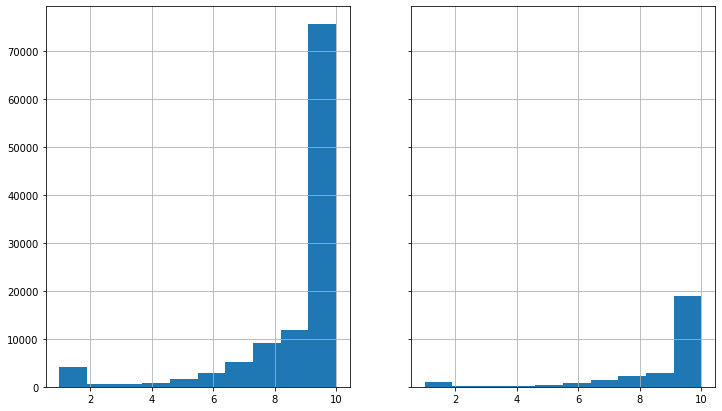

In [16]:
# show data in graphs

fig,ax=plt.subplots(1,2,sharex='col',sharey='row',figsize=(12,7))
ax=ax.ravel()

train_df['rate'].hist(ax=ax[0])
val_df['rate'].hist(ax=ax[1])

In [19]:
# print train_df.rating information

print(train_df['rate'].describe())

count    112568.000000
mean          8.951825
std           2.106672
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64


Load dataframe
> load related dataframe and combine 



In [20]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

In [21]:
movies_df.head()

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국
